In [1]:
from fonduer.supervision import Labeler
from fonduer.supervision.models import GoldLabel
from fonduer.features import Featurizer
from fonduer.candidates.models import Candidate
from fonduer.parser.models import Document

from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import LabelModel

from MeMoKBC.pipeline.utils import get_session, load_candidates, match_label_matrix
from MeMoKBC.definitions.candidates import NameFullAbbr, NameAbbrTask
from MeMoKBC.pipeline.lfs.name_short_long_lfs import short_long_lfs
from MeMoKBC.pipeline.lfs.name_short_task_lfs import name_abbr_task_lfs
from MeMoKBC.gold_label_matcher import match_gold_label

import numpy as np
from random import sample
import random
random.seed(1)

In [2]:
session = get_session("pipeline6")

[2023-07-06 20:23:53,550][INFO] fonduer.meta:49 - Setting logging directory to: /tmp/2023-07-06_20-23-53


In [3]:
candidates = [NameFullAbbr, NameAbbrTask]

In [4]:
# Load goldlabels from json file and compare to candidates in database
gold_labels = match_gold_label(
    "pipeline6",
    "/data/Goldlabel_biomedRxiv/goldlabel1_docs801-840_laura/goldlabel_authorlong_short_task_medRxiv.json",
    [NameAbbrTask, NameFullAbbr]
)

# filter potential goldlabels after candidate class
nat_cands = []
nfa_cands = []
for cand in gold_labels:
    if type(cand) == NameAbbrTask:
        # remove candidates where short and long name are not in the same sentence
        if cand[0].context.sentence.id == cand[1].context.sentence.id:
            # append the id of the candidate to the list
            nat_cands.append(cand.id)
    elif type(cand) == NameFullAbbr:
        # append the id of the candidate to the list
        nfa_cands.append(cand.id)

[2023-07-06 20:23:53,827][INFO] fonduer.meta:134 - Connecting user:postgres to fonduer-postgres-dev:5432/pipeline6
[2023-07-06 20:23:53,829][INFO] fonduer.meta:162 - Initializing the storage schema
[2023-07-06 20:23:54,076][INFO] root:88 - Found relations for 22 documents
[2023-07-06 20:23:54,372][INFO] root:93 - Found 6820 candidates for <class 'fonduer.candidates.models.candidate.NameAbbrTask'>
[2023-07-06 20:23:54,832][INFO] root:93 - Found 28105 candidates for <class 'fonduer.candidates.models.candidate.NameFullAbbr'>
[2023-07-06 20:23:55,224][INFO] root:102 - Found candidates for 40 documents


Now that know which Candidates are our GoldLabels we still need to inform Fonduer of this. To be able to write this information into the db Fonduer needs a funktion that labels these candidates as Goldlabels.

In [5]:
# create labeler object
labeler = Labeler(session, candidates)

# write function that returns gold label for a candidate
def gold(c: Candidate) -> int:
    if type(c) == NameAbbrTask:

        # check if the candidate id is inside the list of goldlabel candidate id's
        if c.id in nat_cands:
            return 1
        else:
            return 0

    elif type(c) == NameFullAbbr:
        
        # check if the candidate id is inside the list of goldlabel candidate id's
        if c.id in nfa_cands:
            return 1
        else:
            return 0
    # if the candidate id is not inside the list of goldlabel candidate id's return FALSE
    return 0

# Apply the gold label function for each candidate class
labeler.apply(lfs=[[gold], [gold]], table=GoldLabel, split=0, clear=True)
labeler.apply(lfs=[[gold], [gold]], table=GoldLabel, split=1)
labeler.apply(lfs=[[gold], [gold]], table=GoldLabel, split=2)

/workspaces/bio-medRxiv/.venv/lib/python3.8/site-packages/fonduer/utils/utils_udf.py:217: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  .filter(candidate_class.id.in_(sub_query))
[2023-07-06 20:24:08,989][INFO] fonduer.supervision.labeler:330 - Clearing Labels (split 0)
/workspaces/bio-medRxiv/.venv/lib/python3.8/site-packages/fonduer/supervision/labeler.py:340: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  query = self.session.query(table).filter(table.candidate_id.in_(sub_query))
[2023-07-06 20:24:09,033][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/14 [00:00<?, ?it/s]

[2023-07-06 20:24:13,881][INFO] fonduer.supervision.labeler:330 - Clearing Labels (split 1)
[2023-07-06 20:24:13,916][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/13 [00:00<?, ?it/s]

[2023-07-06 20:24:20,374][INFO] fonduer.supervision.labeler:330 - Clearing Labels (split 2)
[2023-07-06 20:24:20,426][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/13 [00:00<?, ?it/s]

To be able to train our Model we need to tell it a set of candidates and their Goldlabels. This input is in the form of two list where each entry represents a candidate. For each candidate their are multiple entries that represent the outcome of the different Labeling functions. The same applies to the GoldLabels, we need a complete list of all candidates where each entry represents the output of the gold function.

In [6]:
# load candidates
train_cands = load_candidates(session, 0, candidates)

# match the candidates with the outcome of the labeling functions to generate input for the label model
L_train_NFA, L_train_NAT = match_label_matrix(session, candidates, 0) 

 # load gold labels list
L_gold_train_NFA, L_gold_train_NAT = labeler.get_gold_labels(train_cands)

### IMPORTANT filter out candidates

In [60]:
L_gold_train_NFA.shape

(5090, 1)

In [59]:
L_gold_train_NFA.sum()

134

In [7]:
labels_to_use_NFA = sample(list(np.where(L_gold_train_NFA == 0)[0]), int(sum(L_gold_train_NFA) * 10))
labels_to_use_NFA.extend(np.where(L_gold_train_NFA == 1)[0])
labels_to_use_NFA.sort()

In [61]:
L_gold_train_NAT.shape

(1736, 1)

In [58]:
L_gold_train_NAT.sum()

109

In [52]:
labels_to_use_NAT = sample(list(np.where(L_gold_train_NAT == 0)[0]), int(sum(L_gold_train_NAT) * 2))
labels_to_use_NAT.extend(np.where(L_gold_train_NAT == 1)[0])
labels_to_use_NAT.sort()

Create the Label Models

In [53]:
from pathlib import Path

gen_model_NFA = LabelModel(cardinality=2)
gen_model_NAT = LabelModel(cardinality=2)

Because the output of the gold labels is 2 dimensional e.g [[0], [1], [0]] we still need to reshape the goldlabels with .reshape(-1) to reduce 1 dimension which will result in -> [0, 1, 0]

In [10]:
gen_model_NFA.fit(L_train=L_train_NFA[labels_to_use_NFA], Y_dev=L_gold_train_NFA.reshape(-1)[labels_to_use_NFA], n_epochs=500, log_freq=100)
gen_model_NFA.save(destination="models/label_model_NFA.pkl")

[2023-07-06 20:24:37,080][INFO] root:905 - Computing O...
[2023-07-06 20:24:37,085][INFO] root:911 - Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s][2023-07-06 20:24:37,094][INFO] root:79 - [0 epochs]: TRAIN:[loss=13.414]
[2023-07-06 20:24:37,174][INFO] root:79 - [100 epochs]: TRAIN:[loss=0.391]


100%|██████████| 500/500 [00:00<00:00, 1249.90epoch/s]
[2023-07-06 20:24:37,491][INFO] root:977 - Finished Training


In [54]:
gen_model_NAT.fit(L_train=L_train_NAT[labels_to_use_NAT], Y_dev=L_gold_train_NAT.reshape(-1)[labels_to_use_NAT], n_epochs=500, log_freq=100)
gen_model_NAT.save(destination="models/label_model_NAT.pkl")

[2023-07-06 20:34:46,504][INFO] root:905 - Computing O...
[2023-07-06 20:34:46,507][INFO] root:911 - Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s][2023-07-06 20:34:46,511][INFO] root:79 - [0 epochs]: TRAIN:[loss=1.009]
[2023-07-06 20:34:46,592][INFO] root:79 - [100 epochs]: TRAIN:[loss=0.008]
100%|██████████| 500/500 [00:00<00:00, 1327.41epoch/s]
[2023-07-06 20:34:46,888][INFO] root:977 - Finished Training


### Generating train marginals

In [12]:
train_marginals_NFA = gen_model_NFA.predict_proba(L_train_NFA[labels_to_use_NFA])

In [55]:
train_marginals_NAT = gen_model_NAT.predict_proba(L_train_NAT[labels_to_use_NAT])

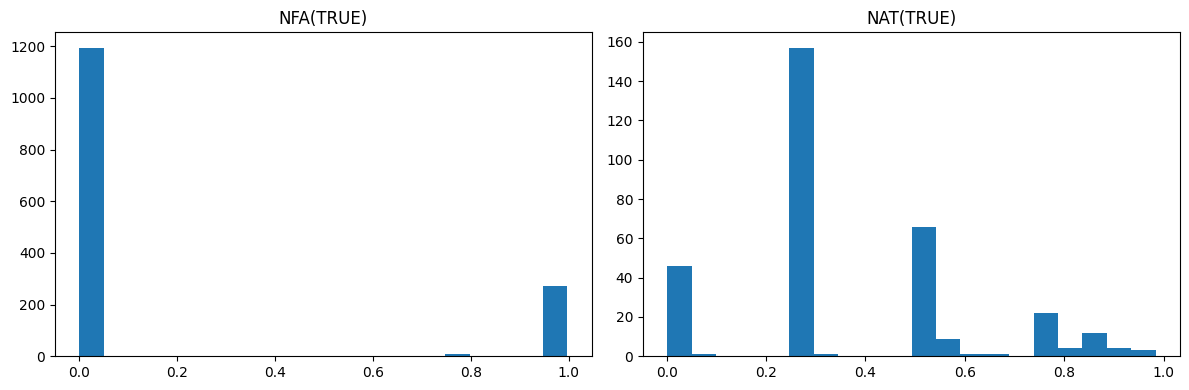

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(12)
fig.set_tight_layout("w_pad")

bins=20

ax[0].hist(train_marginals_NFA[:, 1], bins=bins)
ax[0].set_title("NFA(TRUE)")

ax[1].hist(train_marginals_NAT[:, 1], bins=bins)
ax[1].set_title("NAT(TRUE)")
plt.show()

### Iterate on LFs

In [15]:
labeler = Labeler(session, candidates)

In [16]:
dev_cands = load_candidates(session, split=1, candidate_list=candidates)

L_dev_NFA, L_dev_NAT = match_label_matrix(session, candidates, 1)

In [17]:
L_gold_dev_NFA, L_gold_dev_NAT = labeler.get_gold_labels(dev_cands)

In [18]:
LFAnalysis(L=L_dev_NFA, lfs=short_long_lfs).lf_summary(Y=L_gold_dev_NFA)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_short_outside_half_percentile_sentence_wise,0,"[0, 1]",1.000000,1.000000,0.094554,5258,453,0.920679
name_full_in_top_percentile_sentence_wise,1,[0],0.140781,0.140781,0.094554,717,87,0.891791
word_count,2,[0],0.055682,0.055682,0.000700,318,0,1.000000
small_letter_count,3,[0],0.030468,0.030468,0.001926,174,0,1.000000
check_all_uppercase_letters,4,[0],0.125897,0.125897,0.080721,632,87,0.878999
check_uppercase_letters,5,[0],0.125897,0.125897,0.080721,632,87,0.878999
check_horizont_abr_short,6,[0],1.000000,1.000000,0.094554,5624,87,0.984766
check_uppercase_letters_short_in_long,7,[0],0.409560,0.409560,0.059884,2274,65,0.972210
check_long_name_not_upper,8,[0],0.873577,0.873577,0.089126,4902,87,0.982562
check_all_abbr_letters_in_long,9,[0],0.996323,0.996323,0.094554,5603,87,0.984710


In [20]:
LFAnalysis(L=L_dev_NAT, lfs=name_abbr_task_lfs).lf_summary(Y=L_gold_dev_NAT)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_length_more_than_three_words,0,[0],0.406737,0.406737,0.006519,1123,0,1.000000
lf_name_short_in_first_words,1,[1],0.014125,0.014125,0.014125,12,27,0.307692
is_medical_abbreviation,2,[0],1.000000,0.789569,0.323434,2679,82,0.970301
sentence_beginning,3,[0],0.234335,0.234335,0.197030,647,0,1.000000
common_verbs_following_abbr,4,[1],0.189062,0.189062,0.189062,16,506,0.030651
verbs_ending_with_past,5,[1],0.255704,0.255704,0.255704,26,680,0.036827
word_before_abbr,6,[1],0.028975,0.028975,0.028975,23,57,0.287500
abbr_is_complete,7,[0],0.065556,0.065556,0.000000,181,0,1.000000


## Discriminative Model

In [21]:
# calculate the diff between true and false prediction probability of each candidate
# the bigger the difference the more certain the model is
# Example True = 0.4 False = 0.6
# diff = 0.6 - 0.4 = 0.2 --> model is very unsure 
diffs_NAT = train_marginals_NAT.max(axis=1) - train_marginals_NAT.min(axis=1)
diffs_NFA = train_marginals_NFA.max(axis=1) - train_marginals_NFA.min(axis=1)

# filter out all candidates where labelmodel is very unsure
# unsure is a diff of smaller then 0.000001
train_idxs_NAT = np.where(diffs_NAT > 0.2)[0].astype(np.int64)
train_idxs_NFA = np.where(diffs_NFA > 0.2)[0].astype(np.int64)

filtered_NAT = train_marginals_NAT[train_idxs_NAT, 1]
filtered_NFA = train_marginals_NFA[train_idxs_NFA, 1]

# Cast continous values to binary for logistic regression model
y_NAT = np.where(filtered_NAT > 0.5, 1, 0)
y_NFA = np.where(filtered_NFA > 0.5, 1, 0)

Get feature matrix and filter with previous filter

In [22]:
featurizer = Featurizer(session, candidates)

In [23]:
F_train_NFA, F_train_NAT = featurizer.get_feature_matrices(train_cands)
X_NFA = F_train_NFA #[train_idxs_NFA, :]
X_NAT = F_train_NAT # [train_idxs_NAT, :]


train logistic regression model

In [31]:
from sklearn.linear_model import LogisticRegression, BayesianRidge

y_NFA = np.where(train_marginals_NFA[:, 1] > 0.5, 1, 0)
clf_NFA = LogisticRegression(max_iter=200).fit(F_train_NFA[labels_to_use_NFA], y_NFA)

y_NAT = np.where(train_marginals_NAT[:, 1] > 0.5, 1, 0)
clf_NAT = LogisticRegression(max_iter=200).fit(F_train_NAT[labels_to_use_NAT], y_NAT)

In [34]:
test_cands = load_candidates(session, 2, candidates)
F_test_NFA, F_test_NAT = featurizer.get_feature_matrices(test_cands)


In [26]:
L_gold_test_NFA, L_gold_test_NAT = labeler.get_gold_labels(test_cands)

In [38]:
labels_to_use_test_NFA = sample(list(np.where(L_gold_test_NFA == 0)[0]), int(sum(L_gold_test_NFA) * 10))
labels_to_use_test_NFA.extend(np.where(L_gold_test_NFA == 1)[0])
labels_to_use_test_NFA.sort()

labels_to_use_test_NAT = sample(list(np.where(L_gold_test_NAT == 0)[0]), int(sum(L_gold_test_NAT) * 2))
labels_to_use_test_NAT.extend(np.where(L_gold_test_NAT == 1)[0])
labels_to_use_test_NAT.sort()

In [66]:
preds_NFA = clf_NFA.predict(F_test_NFA[labels_to_use_test_NFA])
preds_NAT = clf_NAT.predict(F_test_NAT[labels_to_use_test_NAT])

In [67]:
from sklearn.metrics import f1_score

In [69]:
f1_score(y_true=L_gold_test_NFA.reshape(-1)[labels_to_use_test_NFA], y_pred=preds_NFA)

0.7208121827411167

In [70]:
f1_score(y_true=L_gold_test_NAT.reshape(-1)[labels_to_use_test_NAT], y_pred=preds_NAT)

0.5365853658536586